In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import matplotlib.collections
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import json
import matplotlib.text as mtext
from colors import Colors
import seaborn as sns

%matplotlib inline
# green mean, yellow median
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
connection = sq.connect("./performance-measurements/merged.db")
connection.row_factory = sq.Row

In [3]:
vantage_points = {
                  'US East':                  {'short': 'us-east_'},
                  'US West':                  {'short': 'us-west_'},
                  'South America East':       {'short': 'sa-east_'},
                  'Europe Central':           {'short': 'eu-central_'},
                  'Asia Pacific Southeast':   {'short': 'ap-southeast_'},
                  'Asia Pacific Northeast':   {'short': 'ap-northeast_'},
                  'Africa South':             {'short': 'af-south_'},
                  'All':                      {'short': ''}
                 }

In [4]:
# filter data by top nameservers of the respective vp
sql = """
CREATE TABLE IF NOT EXISTS dns_measurements_topfive AS
SELECT * 
FROM dns_measurements_clean WHERE 
((ip = '34.86.106.186' OR ip = '150.136.110.156' OR ip = '147.182.175.157' OR ip = '94.140.14.140' OR ip = '69.251.252.106') AND id LIKE 'us-east_%') OR
((ip = '47.254.64.251' OR ip = '45.61.53.161' OR ip = '94.140.15.15' OR ip = '173.230.153.18' OR ip = '172.86.125.249') AND id LIKE 'us-west_%') OR
((ip = '94.140.14.14' OR ip = '35.156.129.204' OR ip = '5.1.84.150' OR ip = '130.61.15.226' OR ip = '82.165.23.176') AND id LIKE 'eu-central_%') OR
((ip = '41.21.230.0' OR ip = '154.0.173.6' OR ip = '45.155.39.173' OR ip = '185.121.25.64' OR ip = '18.135.203.88') AND id LIKE 'af-south_%') OR
((ip = '202.218.2.19' OR ip = '152.69.204.173' OR ip = '218.251.80.123' OR ip = '45.78.53.214' OR ip = '116.80.43.177') AND id LIKE 'ap-northeast_%') OR
((ip = '94.140.14.140' OR ip = '112.213.39.133' OR ip = '209.17.118.5' OR ip = '139.99.239.191' OR ip = '157.245.202.244') AND id LIKE 'ap-southeast_%') OR
((ip = '147.182.175.157' OR ip = '158.101.98.125' OR ip = '94.140.14.15' OR ip = '23.95.234.3' OR ip = '69.251.252.106') AND id LIKE 'sa-east_%');
"""
cursor = connection.cursor()
cursor.execute(sql)
connection.commit()
cursor.close()

In [5]:
sql = """
CREATE TABLE IF NOT EXISTS traceroutes_topfive AS
SELECT * FROM traceroutes_small
WHERE dns_measurement_id IN (SELECT id FROM dns_measurements_topfive);
"""
cursor = connection.cursor()
cursor.execute(sql)
connection.commit()
cursor.close()

In [29]:
def quic_drop_dups(measurements_quic):
    # not used, instead we create a cleaned table
    # drop duplicates on floored timestamp and ip -> this removes resolvers with doubled ports (e.g. adguard)
    measurements_quic['created_datetime'] = pd.to_datetime(measurements_quic['created'], unit='s')
    measurements_quic['created_datetime_hour'] = measurements_quic['created_datetime'].dt.floor('h')
    measurements_quic_cleaned = measurements_quic.drop_duplicates(['ip', 'created_datetime_hour'])
    measurements_quic_cleaned.drop(['created_datetime', 'created_datetime_hour'], axis=1, inplace=True)
    return measurements_quic_cleaned
    
def average(items, key):
    total = 0
    for item in items:
        try:
            total += item[key]
        except:
            pass
    return total/len(items)

def getTraceroutesForProtocol(protocol, vp=''):
    def generateStatement(protocol, vp):
        return "SELECT ip FROM dns_measurements_topfive {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming AND measurement.id LIKE '{}%'".format(protocol, protocol, protocol, protocol, protocol, vp)
    statements = {
        "udp": generateStatement("udp", vp),
        "tcp": generateStatement("tcp", vp),
        "tls": generateStatement("tls", vp),
        "https": generateStatement("https", vp),
        "quic": generateStatement("quic", vp)
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes_topfive WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = '{}' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({}));
    """.format(protocol, vp, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutesPairwise(vp=''):
    udp = getTraceroutesForProtocolPairwise("udp", vp)["rtt"].div(1000000)
    tcp = getTraceroutesForProtocolPairwise("tcp", vp)["rtt"].div(1000000)
    tls = getTraceroutesForProtocolPairwise("tls", vp)["rtt"].div(1000000)
    https = getTraceroutesForProtocolPairwise("https", vp)["rtt"].div(1000000)
    quic = getTraceroutesForProtocolPairwise("quic", vp)["rtt"].div(1000000)
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, showfliers = False)

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.title("RTT for Hosts with all Protocols Reachable")

    plt.show(bp)
    
    df = pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [len(udp), len(tcp), len(tls), len(https), len(quic)]
    })
    print(df.to_markdown())
    
def getTraceroutesForProtocolPairwise(protocol, vp=''):
    def generateStatement(protocol, vp):
        return "SELECT ip FROM dns_measurements_topfive {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND {}.id LIKE '{}%'".format(protocol, protocol, protocol, protocol, protocol, protocol, vp)
    statements = {
        "udp": generateStatement("udp", vp),
        "tcp": generateStatement("tcp", vp),
        "tls": generateStatement("tls", vp),
        "https": generateStatement("https", vp),
        "quic": generateStatement("quic", vp)
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes_topfive WHERE dns_measurement_id LIKE '{}%' AND (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = '{}' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_topfive WHERE protocol = 'udp')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_topfive WHERE protocol = 'quic')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_topfive WHERE protocol = 'tcp')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_topfive WHERE protocol = 'tls')
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes_topfive WHERE protocol = 'https');
    """.format(vp, protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutes(vp=''):
    udp_df = getTraceroutesForProtocolPairwise("udp", vp)
    udp_df["rtt"] = udp_df["rtt"].div(1000000)
    tcp_df = getTraceroutesForProtocolPairwise("tcp", vp)
    tcp_df["rtt"] = tcp_df["rtt"].div(1000000)
    tls_df = getTraceroutesForProtocolPairwise("tls", vp)
    tls_df["rtt"] = tls_df["rtt"].div(1000000)
    https_df = getTraceroutesForProtocolPairwise("https", vp)
    https_df["rtt"] = https_df["rtt"].div(1000000)
    quic_df = getTraceroutesForProtocolPairwise("quic", vp)
    quic_df["rtt"] = quic_df["rtt"].div(1000000)
    
    
    udp = udp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tcp = tcp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tls = tls_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    https = https_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    quic = quic_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    
    return {'UDP': udp, 'TCP': tcp, 'TLS': tls, 'HTTPS': https, 'QUIC': quic}
        
def getQUICMedianTraceroutes(cacheWarming = False, protocol = "quic", vp=''):
    cacheCondition = "AND NOT d.cache_warming" if not cacheWarming else "AND d.cache_warming"
    sql = """
    SELECT
       d.id, d.ip, d.port, d.protocol, d.q_ui_c_handshake_duration as quic_handshake_duration, d.query_time, d.tcp_handshake_duration, d.tls_handshake_duration, d.total_time, d.q_ui_c_version
    FROM dns_measurements_topfive d
    WHERE d.protocol = '{}' {}
    AND d.id LIKE '{}%'
    AND d.id IN (SELECT DISTINCT(t.dns_measurement_id) FROM traceroutes_topfive t where t.protocol = '{}');
    """.format(protocol, cacheCondition, vp, protocol)
    handshake_duration = pd.read_sql_query(sql, connection)
    sql = """
    SELECT
    t.dns_measurement_id as id, dest_port as port, protocol, dest_ip, hop_ip, rtt
    FROM traceroutes_topfive t
    WHERE t.protocol = '{}' AND id LIKE '{}%'
    """.format(protocol, vp)
    rtts = pd.read_sql_query(sql, connection).groupby("id").sample(n = 1)
    return pd.merge(handshake_duration, rtts, on = ["id", "protocol", "port"])

def getQUICMedianResolveTime(vp=''):
    sql = f"""
    SELECT ip, query_time FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'quic' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    quic_df = pd.read_sql_query(sql, connection)
    
    quic_df["query_time"] = quic_df["query_time"].div(1000000)
    
    quic = quic_df.groupby("ip")["query_time"].median().reset_index()
    return quic

def getUDP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'udp' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTCP(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'tcp' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTLS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'tls' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getHTTPS(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'https' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUIC(vp=''):
    sql = f"""
    SELECT * FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'quic' AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND measurement.id LIKE '{vp}%'
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements_topfive https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICNegotiatedProtocol(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_negotiated_protocol FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'quic'
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICVersions(vp=''):
    sql = f"""
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_version FROM dns_measurements_topfive measurement
    WHERE measurement.protocol = 'quic'
    AND NOT measurement.cache_warming
    AND measurement.id LIKE '{vp}%';
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getNumberOfSamples(vp=''):
    udp = len(getUDP(vp))
    tcp = len(getTCP(vp))
    tls = len(getTLS(vp))
    https = len(getHTTPS(vp))
    quic = len(getQUIC(vp))
    return pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [udp, tcp, tls, https, quic]
    })

def getData(vp=''):
    udp = getUDP(vp)
    tcp = getTCP(vp)
    tls = getTLS(vp)
    https = getHTTPS(vp)
    quic = getQUIC(vp)
    return pd.DataFrame(udp + tcp + tls + https + quic, columns = udp[0].keys())

def calculateCDF(items):
    count, bins_count = np.histogram(items, bins=400)

    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    # zeros in front?
    # cdf = np.insert(cdf, 0, 0.)
    # return bins_count, cdf
    return bins_count[1:], cdf

def setBoxesWhite(bp):
    for patch in bp['boxes']:
        patch.set_facecolor("white")

In [31]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def print_cdf_values(dict_key, percentage):
    data = {'QUIC': [], 'TLS': [], 'HTTPS': [], 'TCP': []}
    keys = []
    for key, vp in vantage_points.items():
        keys.append(key)
        st = vp[dict_key]

        x,y = calculateCDF(st['QUIC'])
        idx, val = find_nearest(y, percentage)
        data['QUIC'].append(int(x[idx]))

        x,y = calculateCDF(st['TLS'])
        idx, val = find_nearest(y, percentage)
        data['TLS'].append(int(x[idx]))

        x,y = calculateCDF(st['HTTPS'])
        idx, val = find_nearest(y, percentage)
        data['HTTPS'].append(int(x[idx]))

        x,y = calculateCDF(st['TCP'])
        idx, val = find_nearest(y, percentage)
        data['TCP'].append(int(x[idx]))
        
    return pd.DataFrame(data, keys)

### Total Servers used

In [7]:
for key, vp in vantage_points.items():
    print(key)
    vp['allData'] = getData(vp['short'])
    print(len(vp['allData']["ip"].unique()))

US East
3
US West
5
South America East
2
Europe Central
5
Asia Pacific Southeast
5
Asia Pacific Northeast
5
Africa South
5
All
29


In [8]:
for key, vp in vantage_points.items():
    vp['UDP'] = getUDP(vp['short'])
    vp['TCP'] = getTCP(vp['short'])
    vp['TLS'] = getTLS(vp['short'])
    vp['HTTPS'] = getHTTPS(vp['short'])
    vp['QUIC'] = getQUIC(vp['short'])

### Average Total Times

In [9]:
for key, vp in vantage_points.items():
    vp['average_total_time'] = {
        'UDP': average(vp['UDP'], "total_time") / 1000000,
        'TCP': average(vp['TCP'], "total_time") / 1000000,
        'TLS': average(vp['TLS'], "total_time") / 1000000,
        'HTTPS': average(vp['HTTPS'], "total_time") / 1000000,
        'QUIC': average(vp['QUIC'], "total_time") / 1000000
    }

In [98]:
row_labels = [key for key in vantage_points]
col_labels = ['UDP', 'TCP', 'TLS', 'HTTPS', 'QUIC']
total_times = [[vp['average_total_time'][protocol] for protocol in col_labels] for key, vp in vantage_points.items()]
total_times_df = pd.DataFrame(total_times, columns=col_labels, index=row_labels)
total_times_df.style.background_gradient(cmap='RdYlGn_r')

,UDP,TCP,TLS,HTTPS,QUIC
US East,9.831151,20.129038,33.444114,34.213345,24.574824
US West,6.013705,14.115831,24.190755,27.391680,19.104483
South America East,126.878087,249.576145,375.222876,382.195072,249.621423
Europe Central,2.563821,8.372595,18.177354,18.710181,12.159608
Asia Pacific Southeast,39.181453,78.626510,124.929763,125.796384,88.145432
Asia Pacific Northeast,4.251014,11.281870,17.666561,18.558675,15.621513
Africa South,97.373392,196.131348,297.895562,298.167641,208.161591
All,34.374571,70.236731,108.938896,110.594124,76.232103


In [11]:
total_times_df.style.background_gradient(cmap='RdYlGn_r', axis=1)

,UDP,TCP,TLS,HTTPS,QUIC
US East,9.831151,20.129038,33.444114,34.213345,24.574824
US West,6.013705,14.115831,24.190755,27.391680,19.104483
South America East,126.878087,249.576145,375.222876,382.195072,249.621423
Europe Central,2.563821,8.372595,18.177354,18.710181,12.159608
Asia Pacific Southeast,39.181453,78.626510,124.929763,125.796384,88.145432
Asia Pacific Northeast,4.251014,11.281870,17.666561,18.558675,15.621513
Africa South,97.373392,196.131348,297.895562,298.167641,208.161591
All,34.374571,70.236731,108.938896,110.594124,76.232103


<AxesSubplot:>

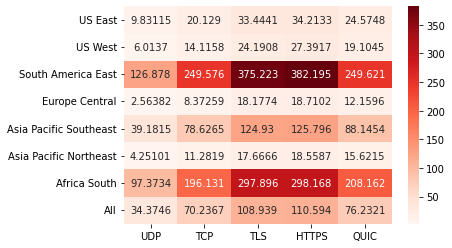

In [12]:
sns.heatmap(total_times_df, annot=True, fmt='g', cmap='Reds')

#### Number of Samples

In [13]:
for key, vp in vantage_points.items():
    vp['number_of_samples'] = getNumberOfSamples(vp['short']).set_index("Protocol")
total_samples = [[vp['number_of_samples'].loc[protocol]['Samples'] for protocol in col_labels] for key, vp in vantage_points.items()]
total_samples_df = pd.DataFrame(total_samples, columns=col_labels, index=row_labels)
total_samples_df

,UDP,TCP,TLS,HTTPS,QUIC
US East,252,252,252,252,252
US West,420,420,420,420,420
South America East,168,168,168,167,168
Europe Central,417,417,417,414,420
Asia Pacific Southeast,420,420,420,420,419
Asia Pacific Northeast,416,414,416,414,416
Africa South,418,419,418,419,417
All,2511,2510,2511,2506,2512


### Comparing Protocols

In [14]:
for key, vp in vantage_points.items():
    vp['query_time'] = {
    'UDP': list(map(lambda x: x["query_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["query_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["query_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["query_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["query_time"] / 1000000, vp['QUIC']))
    }

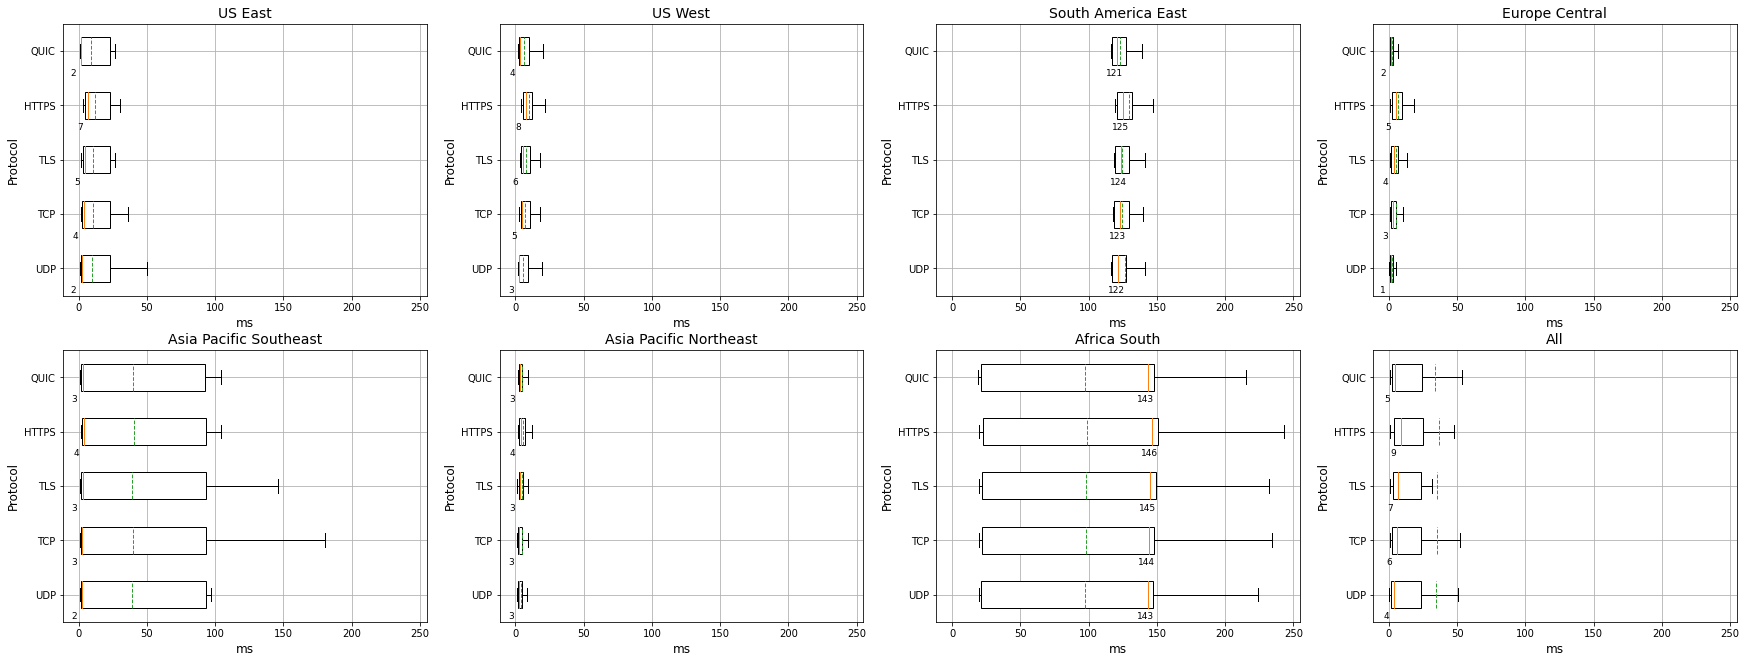

In [15]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    qt = vp['query_time']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([qt['UDP'], qt['TCP'], qt['TLS'], qt['HTTPS'], qt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 8, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax.tick_params(labelbottom=True)
    ax.set_xlabel('ms', fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.grid()
    i += 1

plt.savefig("figures/topfive_resolve_time_boxplot.pdf", bbox_inches='tight')
plt.show()

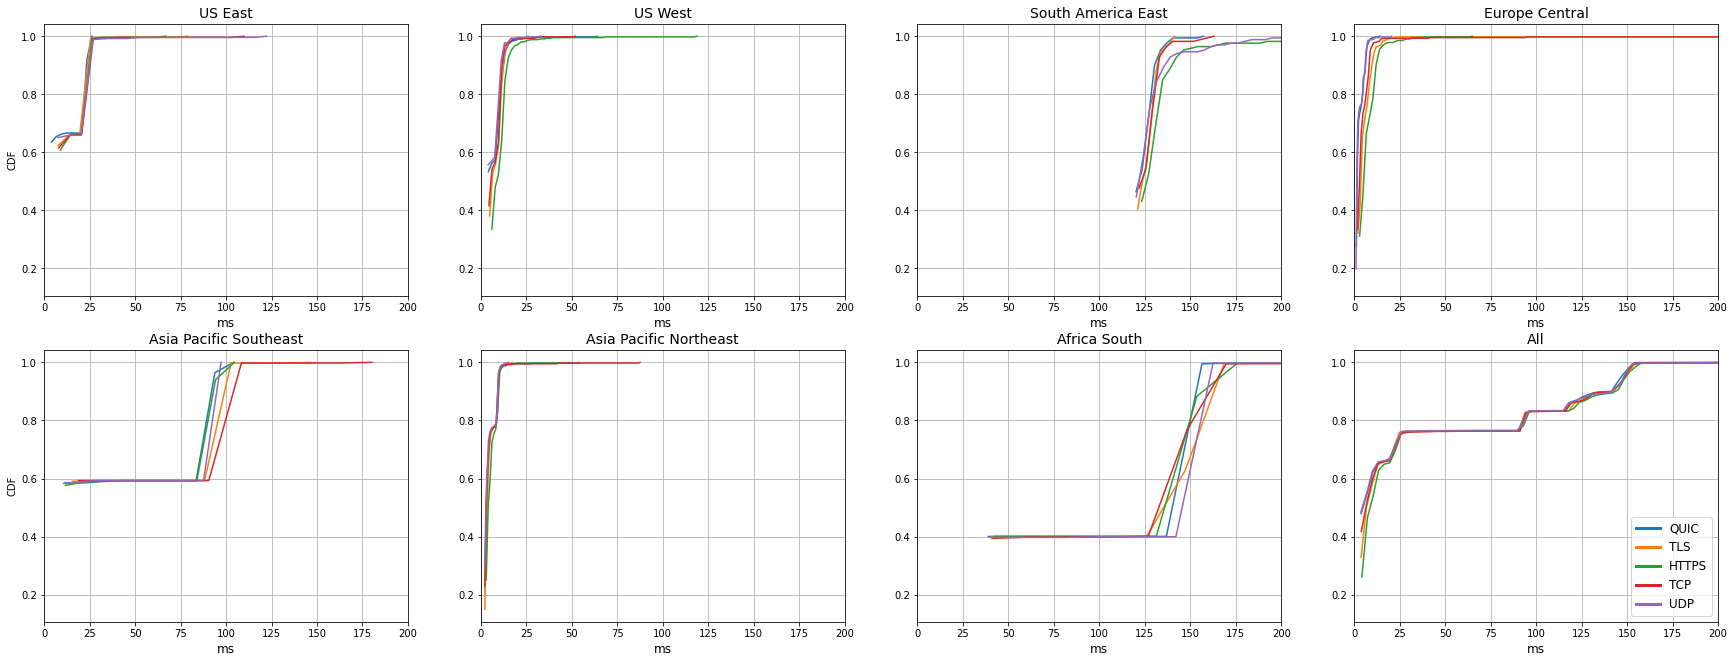

In [16]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)

for key, vp in vantage_points.items():
    qt = vp['query_time']
    ax = axs[int(i/4),i%4]
    sns.lineplot(x=calculateCDF(qt['QUIC'])[0], y=calculateCDF(qt['QUIC'])[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(qt['TLS'])[0], y=calculateCDF(qt['TLS'])[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(qt['HTTPS'])[0], y=calculateCDF(qt['HTTPS'])[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(qt['TCP'])[0], y=calculateCDF(qt['TCP'])[1], label="TCP", ax=ax)
    sns.lineplot(x=calculateCDF(qt['UDP'])[0], y=calculateCDF(qt['UDP'])[1], label="UDP", ax=ax)
    
    ax.set_xlim(0, 200)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1
    
plt.savefig("figures/topfive_resolve_time_cdf.pdf", bbox_inches='tight')
plt.show()

### Average resolve time

In [17]:
np.set_printoptions(precision=3)
for key, vp in vantage_points.items():
    vp['average_query_time'] = {
        'UDP': round(average(vp['UDP'], "query_time") / 1000000, 2),
        'TCP': round(average(vp['TCP'], "query_time") / 1000000, 2),
        'TLS': round(average(vp['TLS'], "query_time") / 1000000, 2),
        'HTTPS': round(average(vp['HTTPS'], "query_time") / 1000000, 2),
        'QUIC': round(average(vp['QUIC'], "query_time") / 1000000, 2)
    }
    print(key)
    print(vp['average_query_time'])

US East
{'UDP': 9.75, 'TCP': 10.5, 'TLS': 10.74, 'HTTPS': 11.84, 'QUIC': 9.12}
US West
{'UDP': 5.94, 'TCP': 7.3, 'TLS': 7.67, 'HTTPS': 9.84, 'QUIC': 6.64}
South America East
{'UDP': 126.81, 'TCP': 124.43, 'TLS': 124.8, 'HTTPS': 129.72, 'QUIC': 122.66}
Europe Central
{'UDP': 2.46, 'TCP': 5.07, 'TLS': 5.22, 'HTTPS': 6.44, 'QUIC': 2.59}
Asia Pacific Southeast
{'UDP': 39.12, 'TCP': 39.5, 'TLS': 39.42, 'HTTPS': 40.25, 'QUIC': 39.5}
Asia Pacific Northeast
{'UDP': 4.19, 'TCP': 4.61, 'TLS': 4.59, 'HTTPS': 5.38, 'QUIC': 4.68}
Africa South
{'UDP': 97.32, 'TCP': 98.2, 'TLS': 98.3, 'HTTPS': 98.87, 'QUIC': 97.1}
All
{'UDP': 34.3, 'TCP': 35.21, 'TLS': 35.3, 'HTTPS': 36.71, 'QUIC': 34.15}


In [18]:
for key, vp in vantage_points.items():
    vp['total_time'] = {
    'UDP': list(map(lambda x: x["total_time"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["total_time"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: x["total_time"] / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: x["total_time"] / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["total_time"] / 1000000, vp['QUIC']))
    }

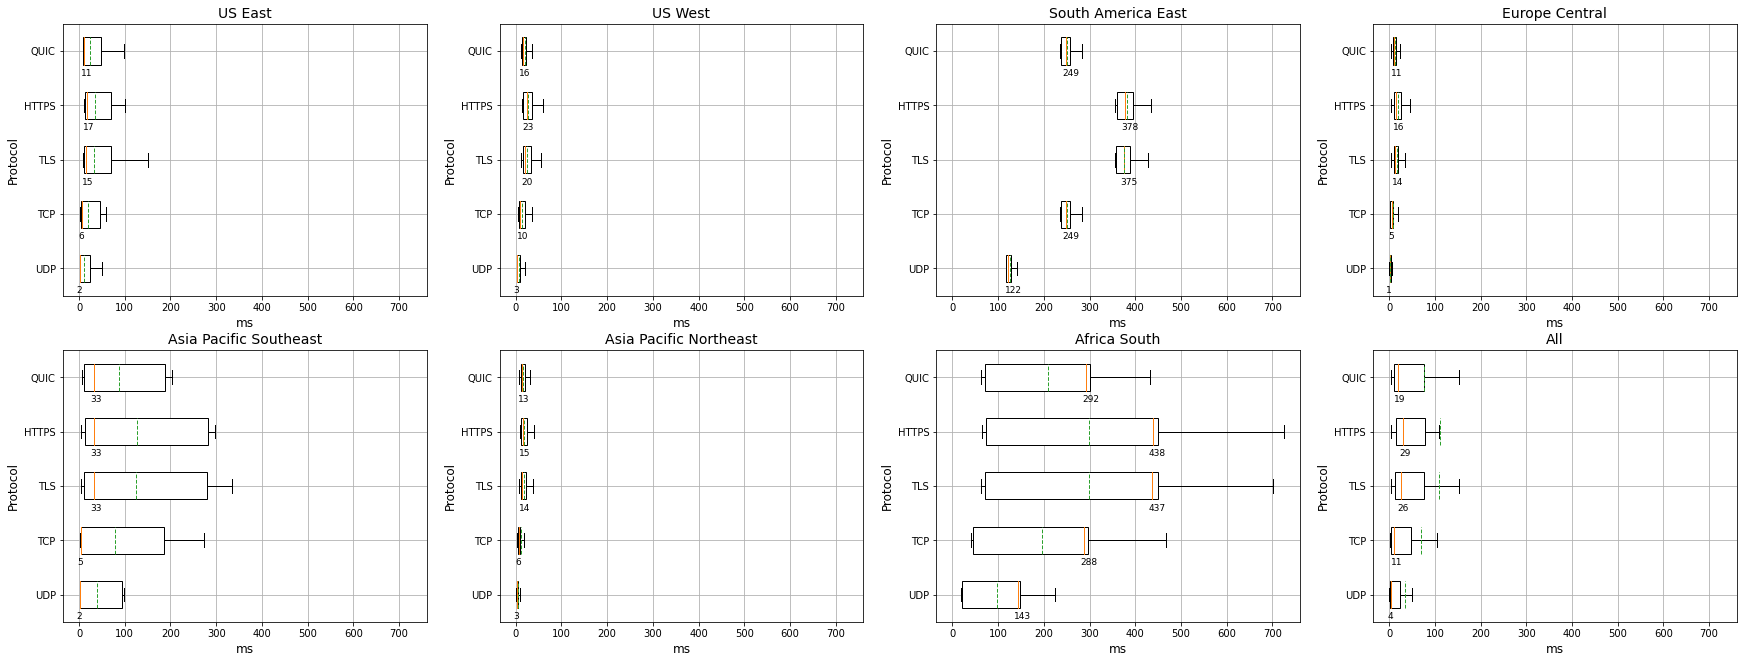

In [19]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharex=True)
for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax = axs[int(i/4),i%4]
    bp = ax.boxplot([tt['UDP'], tt['TCP'], tt['TLS'], tt['HTTPS'], tt['QUIC']], vert = 0, sym = "", patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 8, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 9, color='black')
    
    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])
    ax.set_xlabel('ms', fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    ax.set_title(key, fontsize = 14)
    ax.tick_params(labelbottom=True)
    ax.grid()
    i += 1

plt.savefig("figures/topfive_total_time_boxplot.pdf", bbox_inches='tight')
plt.show()

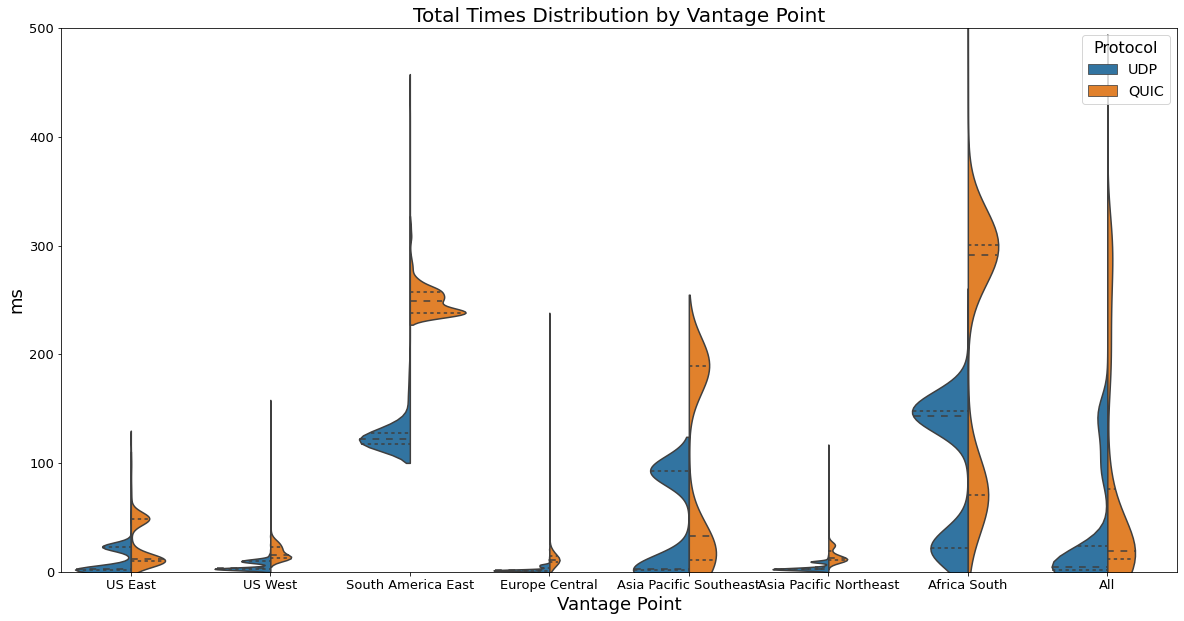

In [20]:
prot_1 = 'UDP'
prot_2 = 'QUIC'

fig, ax = plt.subplots(figsize=(20, 10))
x = []
y = []
z = []
for key, vp in vantage_points.items():
    ttu = vp['total_time'][prot_1]
    x.extend(len(ttu) * [key])
    y.extend(ttu)
    z.extend(len(ttu) * [prot_1])
    
    ttq = vp['total_time'][prot_2]
    x.extend(len(ttq) * [key])
    y.extend(ttq)
    z.extend(len(ttq) * [prot_2])
    
data = pd.DataFrame(dict(x=x, y=y, z=z))

ax.set_title('Total Times Distribution by Vantage Point', fontsize = 20)
ax.set_ylim(0, 500)

v = sns.violinplot(data=data, x='x', y='y',
               split=True, hue = 'z',
               ax = ax, inner='quartile',
               bw = 0.3)
v.set_xlabel('Vantage Point', fontsize = 18)
v.set_ylabel('ms', fontsize = 18)
v.tick_params(labelsize=13)

plt.legend(title='Protocol', fontsize='x-large', title_fontsize='16')
plt.savefig("figures/topfive_total_time_violinplot.pdf", bbox_inches='tight')
plt.show()

In [21]:
for key, vp in vantage_points.items():
    vp['setup_time'] = {
    'UDP': list(map(lambda x: x["udp_socket_setup_duration"] / 1000000, vp['UDP'])),
    'TCP': list(map(lambda x: x["tcp_handshake_duration"] / 1000000, vp['TCP'])),
    'TLS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['TLS'])),
    'HTTPS': list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, vp['HTTPS'])),
    'QUIC': list(map(lambda x: x["q_ui_c_handshake_duration"] / 1000000, vp['QUIC']))
    }

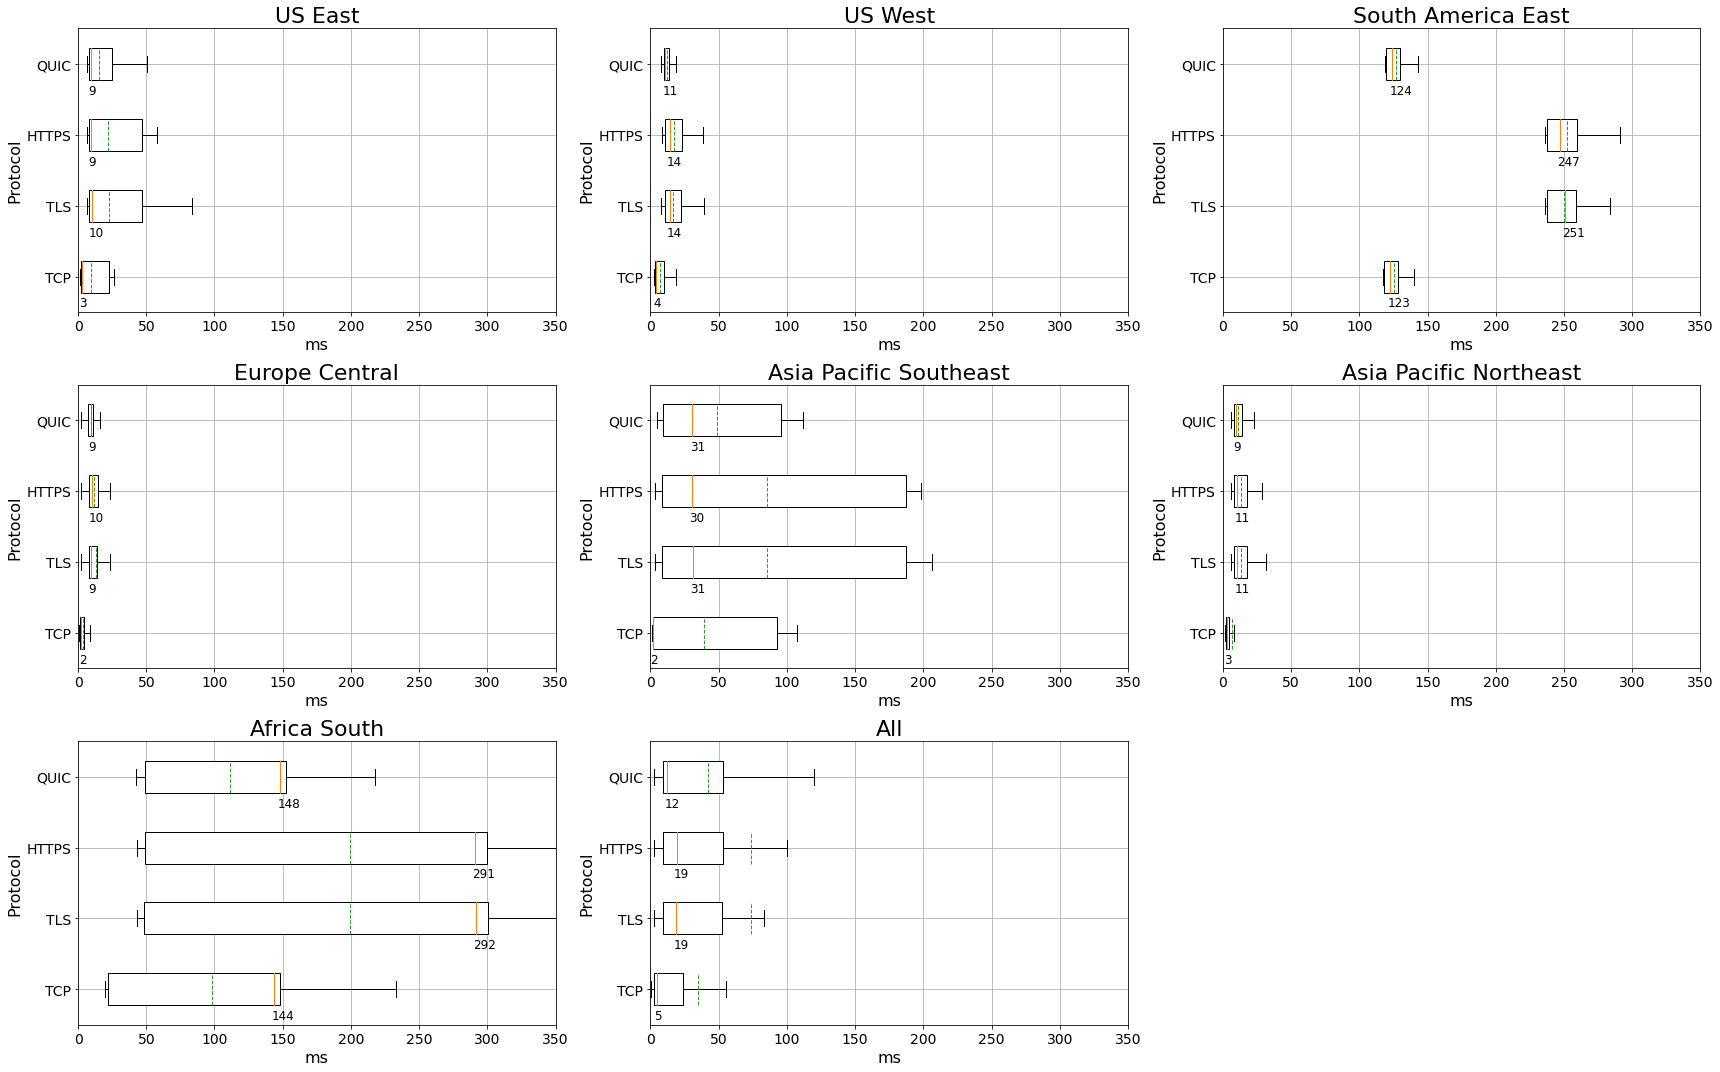

In [96]:
i = 0
fig, axs = plt.subplots(3, 3, figsize=(24, 15), sharex=True)

for key, vp in vantage_points.items():
    st = vp['setup_time']
    ax = axs[int(i/3),i%3]
    bp = ax.boxplot([st['TCP'], st['TLS'], st['HTTPS'], st['QUIC']], vert = 0, showfliers = False, patch_artist=True, meanline = True, showmeans = True)
    setBoxesWhite(bp)

    for median in bp["medians"]:
        x, y = median.get_data()
        ax.text(x[0] - 2, y[0] - 0.2, "{:.0f}".format(x[0]), fontsize = 12, color='black')

    ax.set_yticklabels(["TCP", "TLS", "HTTPS", "QUIC"])
    ax.set_xlabel("ms", fontsize = 16)
    ax.set_ylabel("Protocol", fontsize = 16)
    ax.set_title(key, fontsize = 22)
    ax.tick_params(labelbottom=True)
    ax.tick_params(labelleft=True)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 350)
    ax.grid()
    i += 1

fig.tight_layout()
axs[2,2].axis('off')
plt.savefig("figures/topfive_handshake_time_boxplot.pdf", bbox_inches='tight')
plt.show(bp)

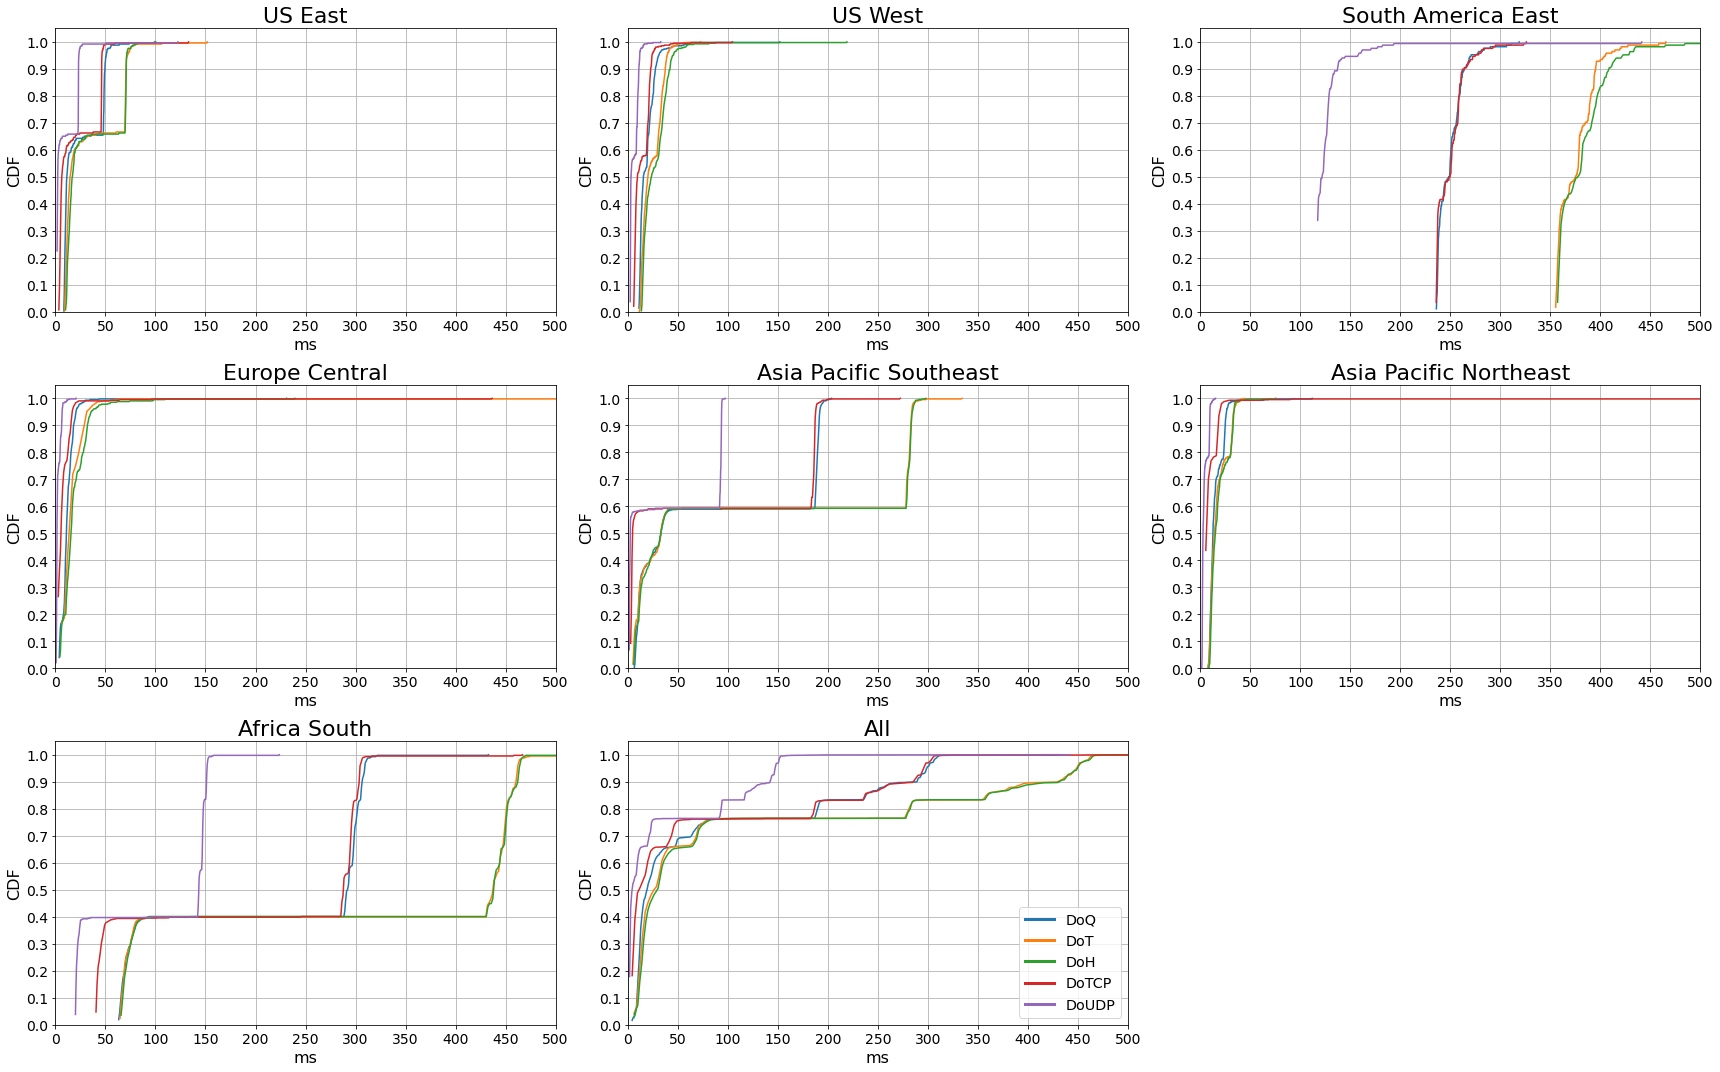

In [94]:
i = 0
fig, axs = plt.subplots(3, 3, figsize=(24, 15), sharey='col')

for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax = axs[int(i/3),i%3]
    sns.lineplot(x=calculateCDF(tt['QUIC'])[0], y=calculateCDF(tt['QUIC'])[1], label="DoQ", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TLS'])[0], y=calculateCDF(tt['TLS'])[1], label="DoT", ax=ax)
    sns.lineplot(x=calculateCDF(tt['HTTPS'])[0], y=calculateCDF(tt['HTTPS'])[1], label="DoH", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TCP'])[0], y=calculateCDF(tt['TCP'])[1], label="DoTCP", ax=ax)
    sns.lineplot(x=calculateCDF(tt['UDP'])[0], y=calculateCDF(tt['UDP'])[1], label="DoUDP", ax=ax)


    ax.set_xlabel("ms", fontsize = 16)
    ax.set_ylabel("CDF", fontsize = 16)
    ax.tick_params(labelleft=True)
    ax.tick_params(labelbottom=True)
    ax.set_title(key, fontsize = 22)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 500)
    ax.xaxis.set_ticks(np.arange(0, 501, 50))
    ax.set_ylim(0.0, 1.05)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))

    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='x-large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1

fig.tight_layout()
axs[2,2].axis('off')
plt.savefig("figures/topfive_total_time_cdf.pdf", bbox_inches='tight')
plt.show()

In [36]:
print_cdf_values('total_time', 0.01)

,QUIC,TLS,HTTPS,TCP
US East,8,8,10,3
US West,11,11,13,5
South America East,236,355,357,235
Europe Central,3,6,4,2
Asia Pacific Southeast,6,5,5,2
Asia Pacific Northeast,8,8,8,5
Africa South,63,64,65,40
All,4,6,5,4


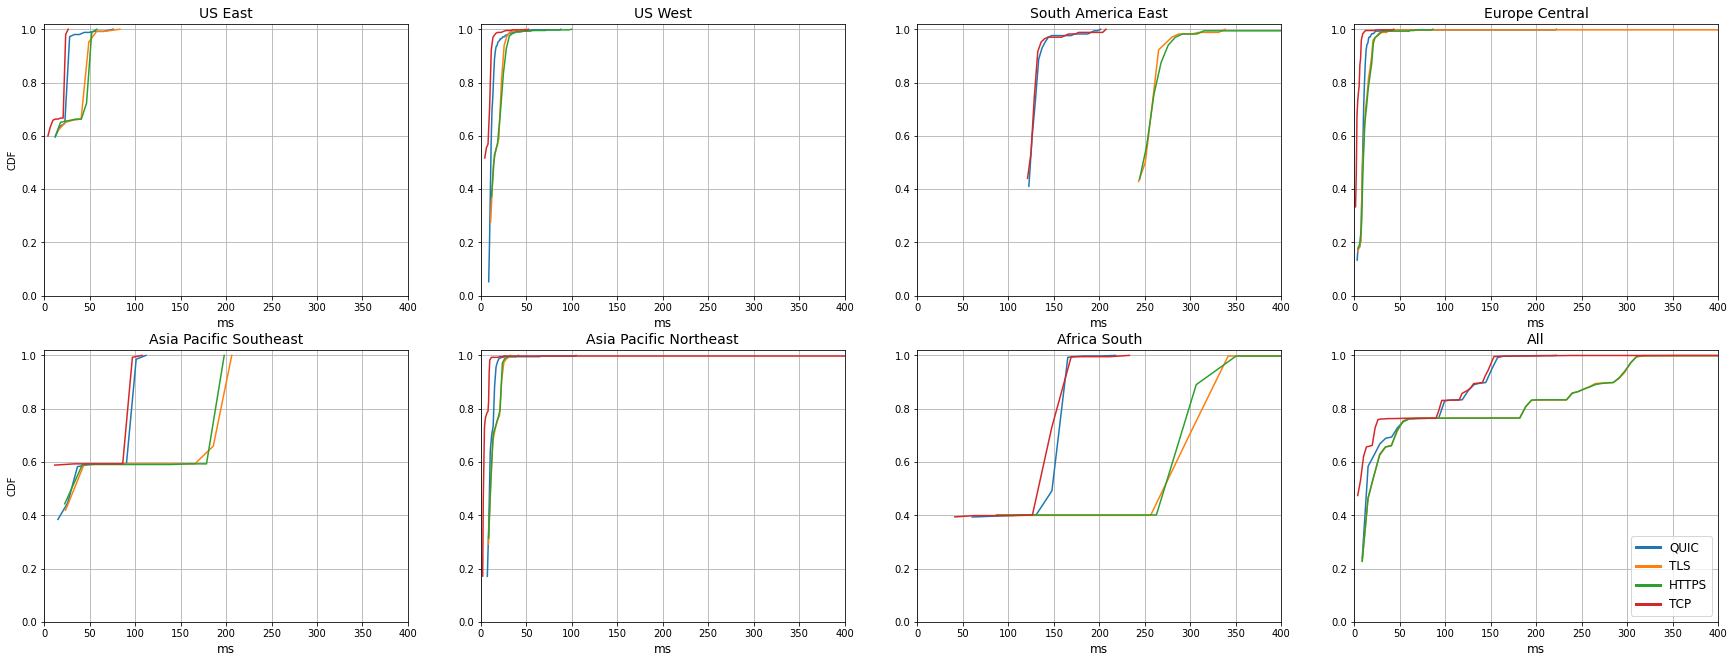

In [24]:
i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)

for key, vp in vantage_points.items():
    st = vp['setup_time']
    ax = axs[int(i/4),i%4]
    sns.lineplot(x=calculateCDF(st['QUIC'])[0], y=calculateCDF(st['QUIC'])[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(st['TLS'])[0], y=calculateCDF(st['TLS'])[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(st['HTTPS'])[0], y=calculateCDF(st['HTTPS'])[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(st['TCP'])[0], y=calculateCDF(st['TCP'])[1], label="TCP", ax=ax)

    ax.set_xlim(0, 400)
    ax.set_ylim(0.0)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1
    
plt.savefig("figures/topfive_setup_time_cdf.pdf", bbox_inches='tight')
plt.show()

### QUIC Handshake Duration / RTT

In [25]:
for key, vp in vantage_points.items():
    vp['times'] = getQUICMedianTraceroutes(vp=vp['short'])
    vp['times']['handshake/rtt'] = vp['times'].apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    vp['times']['resolve-rtt'] = vp['times'].apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

In [26]:
for key, vp in vantage_points.items():
    vp['times_uncached'] = getQUICMedianTraceroutes(cacheWarming = True, vp=vp['short'])
    vp['times_uncached']["resolve-rtt"] = vp['times_uncached'].apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

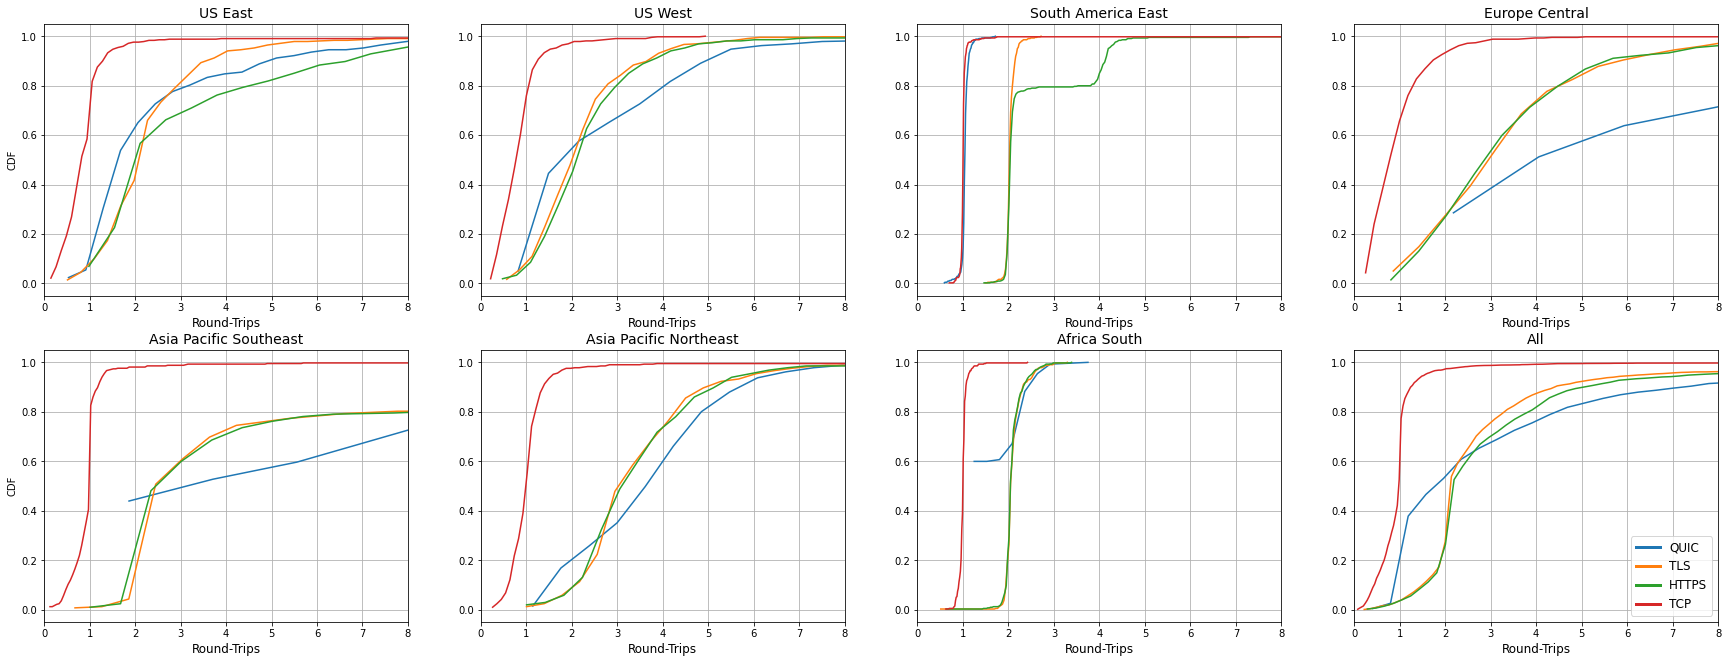

In [27]:
def plotHandshake(ax, vp):
    def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
    def addTLS(row):
        if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
            return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
        return np.nan
    
    vp_short=vp['short']
    quicTimes = getQUICMedianTraceroutes(protocol = "quic", vp=vp_short)
    tcpTimes = getQUICMedianTraceroutes(protocol = "tcp", vp=vp_short)
    tlsTimes = getQUICMedianTraceroutes(protocol = "tls", vp=vp_short)
    httpsTimes = getQUICMedianTraceroutes(protocol = "https", vp=vp_short)
    quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
    tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
    httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)
    
    distQUIC = filterNA(quicTimes)
    distTCP = filterNA(tcpTimes)
    distTLS = filterNA(tlsTimes)
    distHTTPS = filterNA(httpsTimes)
    
    sns.lineplot(x=calculateCDF(distQUIC)[0], y=calculateCDF(distQUIC)[1], label="QUIC", ax=ax)
    sns.lineplot(x=calculateCDF(distTLS)[0], y=calculateCDF(distTLS)[1], label="TLS", ax=ax)
    sns.lineplot(x=calculateCDF(distHTTPS)[0], y=calculateCDF(distHTTPS)[1], label="HTTPS", ax=ax)
    sns.lineplot(x=calculateCDF(distTCP)[0], y=calculateCDF(distTCP)[1], label="TCP", ax=ax)

    ax.set_xlim(0, 8)
    ax.tick_params(labelleft=True)
    ax.set_xlabel("Round-Trips", fontsize = 12)
    ax.set_ylabel("CDF")
    ax.set_title(key, fontsize = 14)
    
    if i == 7:
        leg = ax.legend(loc="lower right", fontsize='large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    plt.xlabel("Round-Trips", fontsize = 12)


i = 0
fig, axs = plt.subplots(2, 4, figsize=(30, 11), sharey=True)
for key, vp in vantage_points.items():
    plotHandshake(axs[int(i/4),i%4], vp)
    i += 1
plt.savefig("figures/topfive_handshake-rtt.pdf", bbox_inches='tight')
plt.show()

In [28]:
connection.close()

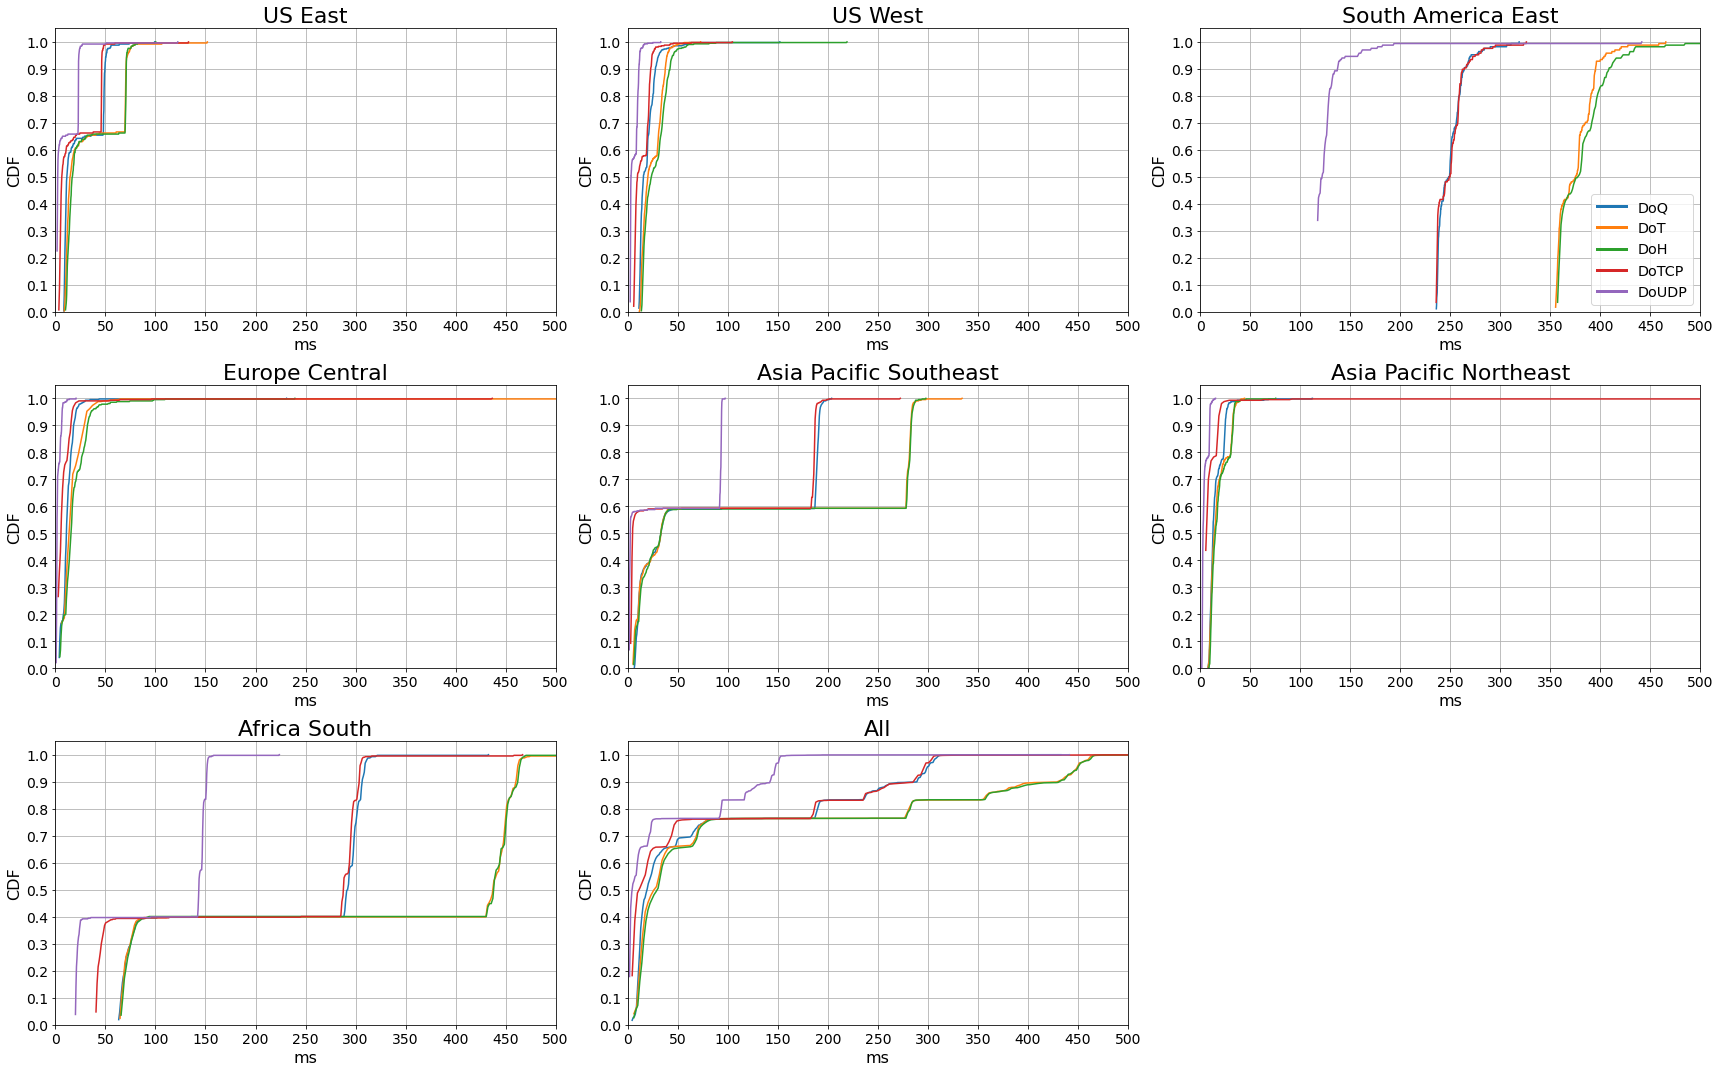

In [99]:
i = 0
fig, axs = plt.subplots(3, 3, figsize=(24, 15), sharey='col')

for key, vp in vantage_points.items():
    tt = vp['total_time']
    ax = axs[int(i/3),i%3]
    sns.lineplot(x=calculateCDF(tt['QUIC'])[0], y=calculateCDF(tt['QUIC'])[1], label="DoQ", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TLS'])[0], y=calculateCDF(tt['TLS'])[1], label="DoT", ax=ax)
    sns.lineplot(x=calculateCDF(tt['HTTPS'])[0], y=calculateCDF(tt['HTTPS'])[1], label="DoH", ax=ax)
    sns.lineplot(x=calculateCDF(tt['TCP'])[0], y=calculateCDF(tt['TCP'])[1], label="DoTCP", ax=ax)
    sns.lineplot(x=calculateCDF(tt['UDP'])[0], y=calculateCDF(tt['UDP'])[1], label="DoUDP", ax=ax)


    ax.set_xlabel("ms", fontsize = 16)
    ax.set_ylabel("CDF", fontsize = 16)
    ax.tick_params(labelleft=True)
    ax.tick_params(labelbottom=True)
    ax.set_title(key, fontsize = 22)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlim(0, 500)
    ax.xaxis.set_ticks(np.arange(0, 501, 50))
    ax.set_ylim(0.0, 1.05)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))

    if i == 2:
        leg = ax.legend(loc="lower right", fontsize='x-large')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    ax.grid()
    i += 1

fig.tight_layout()
axs[2,2].axis('off')
plt.savefig("figures/topfive_total_time_cdf_presentation.pdf", bbox_inches='tight')
plt.show()